<H1>Personalized Medecine : Redefining Cancer treatment</H1>

-------------------


<font size=3.5 ><text><strong>Classify Gene mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers)</strong></text></font>
<br>
Once sequenced, a cancer tumor can have thousands of genetic mutations. But thanks to this KAGGLE challenge, the model built will distinguish the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 
<br>
Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.
<br>
<br>
<font size=3.5><strong>Here is the notebook structure</strong></font>
<br><br>
<ul>
<li>I   – <a href="#chapI">Explore data provided in the Kaggle files</a></li>
<li>II  – <a href="#chapII">Feature engineering</a></li>
<li>III - <a href="#chapIII">Vectorize Text feature</a></li>
<li>IV  - <a href="#chapIV">Build model</a></li>
</ul>

<br><font size=2 ><text>The Kaggle Platform provides here the datasets for the <b><font color='blue'>"<a href="https://www.kaggle.com/c/msk-redefining-cancer-treatment">Personalized Medecine : Redefining Cancer treatment</a>"</font></b> competition.</text></font></br>
<br>
<font size = 3.5><strong>Variables in the dataset</strong></font><br>
We have 2 sets of files to explore and use to predict the gene mutation type<br>
<br>
<u>Among these variables we have in the training/test_variants:</u>
<br><b>ID</b> : the id of the row used to link the mutation to the clinical evidence<br>
<b>Gene</b> : the gene where this genetic mutation is located<br>
<b>Variation</b> : the aminoacid change for this mutations<br>
<b>Class</b> (for the training_variant): 1-9 the class this genetic mutation has been classified on<br>
<br>
<u>Among these variables we have in the train/test_text:</u><br>
<b>ID</b> : the id of the row used to link the clinical evidence to the genetic mutation<br>
<b>Text</b> : the clinical evidence used to classify the genetic mutation<br>



In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

#Open the dataset files
training_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
training_text_df = pd.read_csv("training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

#Display the train sets structure
print("Training sets structure :")
print("training variants " + str(training_variants_df.shape) + "  & text shape " + str(training_text_df.shape))
print("")

#Display first training lines
print(training_variants_df.head())


C:\Users\Ludovic\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Ludovic\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training sets structure :
training variants (3321, 4)  & text shape (3321, 2)

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [2]:
#Join variants and text DataFrames on ID for train and test
train = pd.merge(training_variants_df, training_text_df, how='left', on='ID')
test = pd.merge(test_variants_df, test_text_df, how='left', on='ID')



## <p id="chapI">I - Explore DATA</p>

--------------------------

--------------------------

<font size=3.5><strong>Look at the data distribution</strong></font>

--------------------

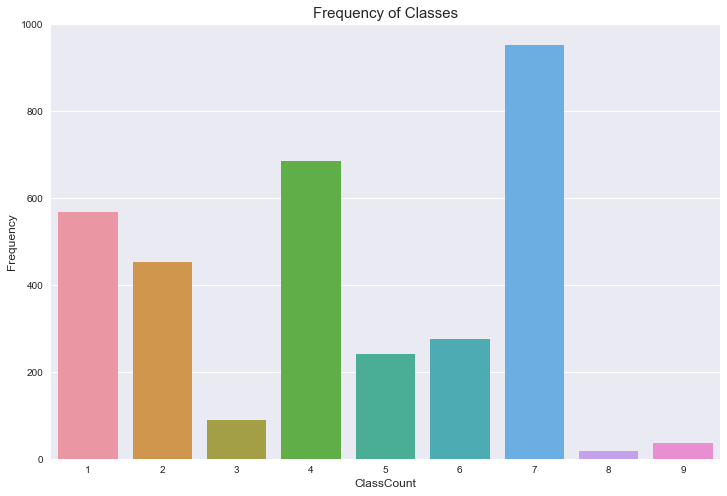

In [3]:
# How is the Class distribution ?
def plot_feature_frequency(feature):
    plt.figure(figsize=(12,8))
    sns.countplot(x=feature, data=train)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(feature+'Count', fontsize=12)
    plt.xticks(rotation='horizontal')
    plt.title("Frequency of Classes", fontsize=15)
    plt.show()

#Plot the class frequency in the train dataset
plot_feature_frequency("Class")

Few example to train for the classes 9 and 8 and not much more for the class 3.

In [4]:
#Have an overview of the joined datasets
train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
#Get the length of the longer text
text_len = train.apply(lambda x : len(x["Text"].split(" ")), axis=1)   #Enumerate the words number for each text provided
max(text_len)                       

77202

The longer text is built with 77 202 words. As discussed in the project presentation, we have very long text that should be time consuming for researcher. 

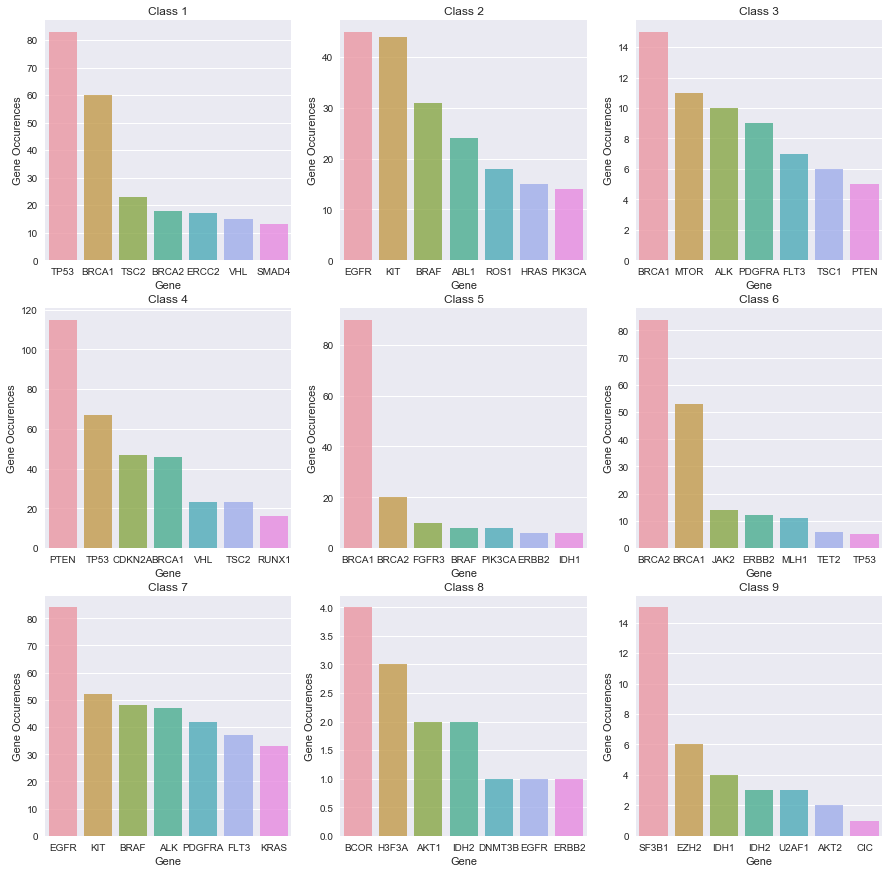

In [6]:
#How is the Gene distribution by Class ?
fig, axis = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

#For each class get the 7 most popular gene
for i in range(3):
    for j in range(3):
        train_class_ij = train[train['Class']==((i*3+j)+1)]   #Select the rows associated at the current class in the inner loop
        gene_pivot_df = train_class_ij.pivot_table(index="Gene", values="ID", aggfunc=lambda x: len(x)).reset_index()   #Count the number of occurences for each Gene     
        gene_pivot_df = gene_pivot_df.sort_values('ID', ascending=False)[:7]
        sns.barplot(x="Gene", y="ID", data=gene_pivot_df, alpha=0.8, ax=axis[i][j])
        axis[i][j].set(xlabel='Gene', ylabel='Gene Occurences', title= "Class "+str((i*3+j)+1))
        


Some class are clearly dominated by some genes. For example, the Class 5 is mainly linked to the gene BRCA1 or the Class 1 by TP53 and BRCA1.

As we have a long <font color='red'>"Text"</font> feature for many observations, we will have a look to check how <font size=3.5><strong>Natural Language Process could help to classify each row.</strong></font> 

<font size=3.5><strong>Add the number of words as a new feature and keep on exploring data</strong></font> 

In [7]:
#Length of train text entry 
#Define a feature as the number of words by text feature
train["Text_num_words"] = train["Text"].apply(lambda x: len(str(x).split()) )
test["Text_num_words"] = test["Text"].apply(lambda x: len(str(x).split()) )


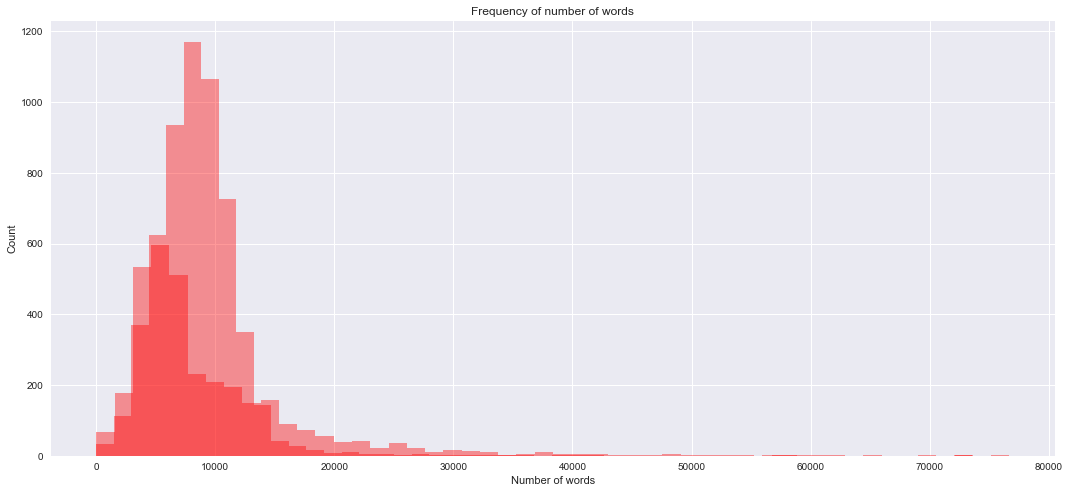

In [8]:
#Plot the number of words distribution for train and text datasets
fig, ax = plt.subplots(figsize=(18, 8))

sns.distplot(train.Text_num_words.values, bins=50, kde=False, color='red',ax=ax)
sns.distplot(test.Text_num_words.values, bins=50, kde=False, color='red',ax=ax)
ax.set(xlabel='Number of words', ylabel='Count', title= "Frequency of number of words")


Train and Test datasets have a similar number of word shape distribution but Test has much longer text description.

Moreover some texts looks very short or almost empty.
<br><br>
<font size = 3.5><strong>What about null values recorded by row ?</strong></font>

In [9]:
#Sum the number of null values by row
test_null_col = test.isnull().sum(axis=1)
test_null_col.value_counts()

0    5668
dtype: int64

BUT there is no null value in the train dataframe

In [10]:
#Display rows having less than 500 words
train[train["Text_num_words"] < 500].sort_values("Gene")

,ID,Gene,Variation,Class,Text,Text_num_words
1378,1378,AKT2,D399N,7,The activating E17K mutations recently discove...,448
1368,1368,AKT2,D32H,7,The activating E17K mutations recently discove...,448
1277,1277,ARID5B,Truncating Mutations,1,null,1
2755,2755,BRAF,G596C,7,null,1
2504,2504,BRCA1,V11A,6,Identification of protein-protein interaction...,230
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,187
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,187
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,187
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ...",103
688,688,CDKN2A,R79P,4,Cell division is controlled by a series of pos...,228


We do not have much rows with "null" text. In this case the model will focus on other features to classify row.
As a consequence we will keep the <font color="red">Text_num_words</font> feature to help classification.

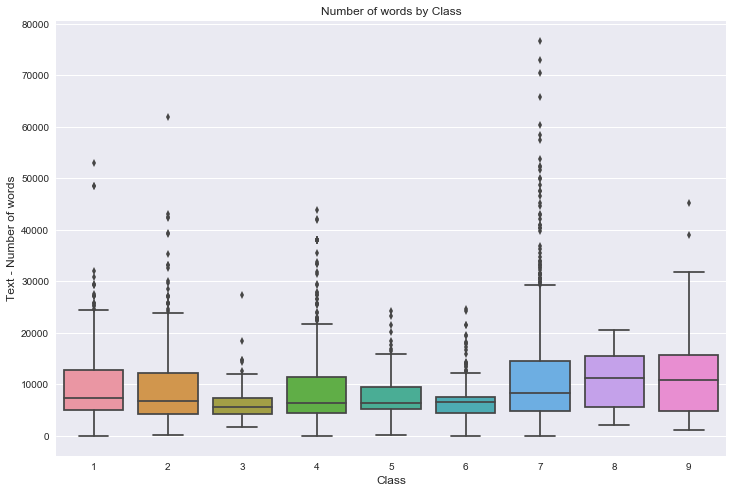

In [11]:
#Plot the number of words distribution for each class in combined text
plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='Text_num_words', data=train)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.title('Number of words by Class')
plt.show()


Classes 3, 5 and 6 have shorter texts than others so text length could help to classify.
The longer texts are wrotten for classes 8 and 9. But these classes are very few represented as shown above.  

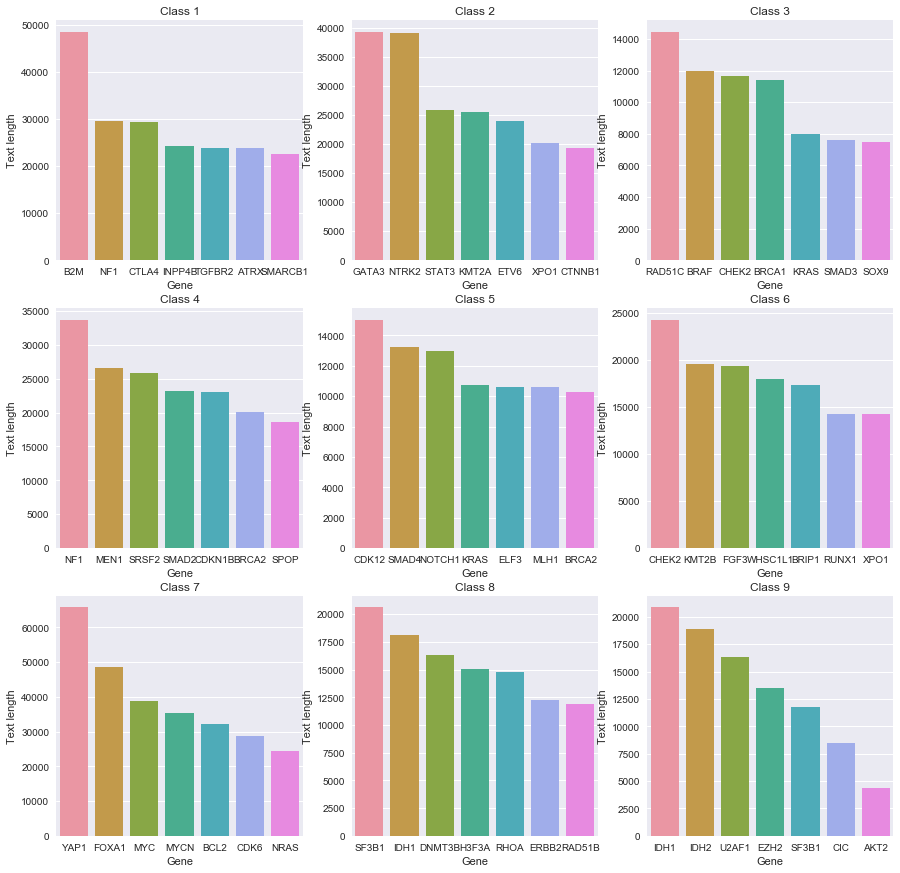

In [12]:
#Plot the number of words distribution for each gene and class
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        gene_count_grp = train[train["Class"]==((i*3+j)+1)].groupby('Gene')["Text_num_words"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_num_words', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_num_words", data=sorted_gene_group_top_7, ax=axs[i][j])
        axs[i][j].set(xlabel='Gene', ylabel='Text length', title= "Class "+str((i*3+j)+1))

The combination of Gene and number of words would help model to define if the gene mutation is a driver for at least Class 1, 2 and 7.

On https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2716785/table/t3-bmi-2006-001/ we can get a list of High priority cancer markers. Proteins having > 500 total citations, >100 citations in 2004, >50% 2004 citations.
So we should use this information to get signal in the texts.
How ?
We will count the word number for each element of this list and look at the length distribution of these words.
As a result it will lead our choice to define the ngram range to vectorize texts.
By this way these "High priority marker" signal should be caught in our word/expression vectorization.


In [13]:
#Get the length distribution and define the TFIDF ngram-range after result analyse
High_priority_cancer_markers = ['Alpha-fetoprotein',
'Carcinoembryonic antigen',
'Epidermal growth factor receptor',
'Kallikrein 3 (prostate specific antigen)',
'Vascular endothelial growth factor A',
'VEGF',
'Albumin',
'CA 125',
'Calcitonin',
'Chromogranin A',
'parathyroid secretory protein 1',
'Corticotropin-lipotropin contains ACTH',
'Estrogen receptor 1',
'Gastrin',
'Progesterone receptor',
'Prolactin',
'S100 alpha chain',
'Somatostatin',
'Thyroglobulin',
'V-erb-b2, Her2/neu',
'Antigen identified by monoclonal antibody Ki-67',
'B-cell CLL/lymphoma 2',
'BCL2-associated X protein',
'Q07814',
'Q07815',
'Beta-2-microglobulin',
'Breast cancer 1 early onset',
'CA 15.3',
'CA 19.9',
'Cadherin 1 type 1 E-cadherin',
'Caspase 3',
'CD44 antigen',
'Cellular tumor antigen p53',
'Coagulation factor II, prothrombin',
'Colony stimulating factor 2',
'Colony stimulating factor 3',
'C-reactive protein',
'Cyclin D1',
'Cyclin-dependent kinase inhibitor 1',
'Erythropoietin',
'Fibrinogen alpha/alpha-E chain',
'Follicle-stimulating hormone',
'Gamma enolase',
'Insulin',
'Interferon gamma',
'Interleukin 2',
'Interleukin 6',
'k-ras',
'Neprilysin, CD10',
'Transferrin',
'Trypsin',
'Tumor necrosis factor (TNF-alpha)',
'Tumor necrosis factor receptor superfamily member 6, fas',
'Von Willebrand Factor',
'Chemokine ligand 5 (CCL5)',
'Chitinase-3 like protein 1, YKL-40',
'Choriogonadotropin beta chain',
'Colony stimulating factor 1 (macrophage)',
'Haptoglobin-1',
'Hepatocyte growth factor',
'Inhibin',
'Interferon-alpha/beta receptor alpha chain',
'Interferon-alpha/beta receptor beta chain',
'Kallikrein 10',
'Kallikrein 11',
'Kallikrein 6',
'Matrix metalloproteinase 3',
'Small inducible cytokine A21',
'CCL21',
'soluble IL-2R alpha',
'Somatotropin growth factor, growth hormone',
'P01242	4.0E+02	(Krassas et al. 2003)',
'Breast cancer 2 early onset',
'Catenin Beta 1',
'Cathepsin D',
'CD15',
'Desmin',
'DNA-(apurinic or apyrimidinic site) lyase, APEX',
'Lutropin beta chain, Luteinizing hormone',
'Parathyroid Hormone',
'Proliferating cell nuclear antigen',
'Tumor necrosis factor ligand superfamily member 8',
'CD30 ligand',
'V-myc myelocytomatosis viral oncogene homolog',
'avian',
'Tumor necrosis factor ligand superfamily member 8',
'CD30',
'17beta- Hydroxysteroid dehydrogenase type 1',
'17HSD1',
'Acid phosphatase prostate',
'Adrenomedullin',
'Aldolase A',
'Alkaline phosphatase bone-specific',
'Alkaline phosphatase, placental type',
'Alpha-1-acid glycoprotein 1, orosomucoid',
'Alpha-1-antitrypsin',
'alpha-2-HS-glycoprotein',
'Alpha-2-macroglobulin',
'Alpha-lactalbumin',
'Angiogenin ribonuclease RNase A family 5',
'Angiopoietin 1',
'Angiopoietin 2',
'Antileukoproteinase 1',
'SLPI',
'Apolipoprotein A1',
'Apolipoprotein A-II',
'Apolipoprotein C-I',
'Apolipoprotein C-III',
'Bone sialoprotein II',
'Brain-derived neurotrophic factor',
'Breast cancer metastasis- suppressor 1',
'BRMS1 mRNA',
'CA 27.29',
'CA 72–4',
'Cathepsin B',
'CC chemokine 4, HCC-4',
'CD44 variant V5 soluble',
'Ceruloplasmin',
'Cervical cancer 1 protooncogene protein p40',
'Chemokine',
'Claudin-3',
'Claudin-4',
'Clusterin',
'Coagulation factor III',
'Coagulation factor XIII A chain',
'Coagulation factor XIII B chain',
'Collagen I c-terminal telopeptide',
'Complement component 3',
'Complement component 4',
'Complement component 7',
'Complement factor H related protein',
'Cyclin-dependent kinase 6',
'Cyclooxygenase-2',
'Cystatin A',
'Cystatin B',
'Cystatin C',
'Cytokeratin 8',
'Diazepam binding inhibitor',
'Endoglin',
'Endothelin 1',
'Epidermal growth factor',
'E-selectin',
'Ferritin H',
'Ferritin, L',
'Fibroblast growth factor 2 (basic)',
'Fibronectin 1',
'Flt-3 ligand',
'Fms-related tyrosine kinase 1',
'VEGFR1',
'Follistatin',
'Fructose- bisphosphate aldolase B',
'Fructose- bisphosphate aldolase C',
'Geminin',
'Glucose-6- phosphate isomerase',
'Glypican-3, n-terminal',
'Growth arrest and DNA-damage- inducible alpha',
'Immunosuppressive acidic protein',
'Insulin-like growth factor 1',
'somatomedin C',
'Insulin-like growth factor 2',
'somatomedin A',
'Insulin-like growth factor binding protein 1',
'Insulin-like growth factor binding protein 2',
'Insulin-like growth factor binding protein 3',
'Intercellular Adhesion Molecule 1',
'Interferon alpha 1',
'Interleukin 1 alpha',
'Interleukin 1 beta',
'Interleukin 10',
'Interleukin 12A',
'Interleukin 16',
'Interleukin 5',
'Interleukin 6 receptor',
'Interleukin 6 signal transducer',
'Interleukin 7',
'Interleukin 8',
'Interleukin 9',
'Interleukin-1 receptor antagonist protein',
'IRAP',
'Kallikrein 14',
'hK14',
'Kallikrein 2 prostatic',
'Kallikrein 5',
'Kallikrein 7',
'Kallikrein 8',
'Keratin 18',
'Keratin, type I cytoskeletal 19, cytokeratin 19',
'Kit ligand',
'Lactotransferrin',
'Leptin',
'L-selectin',
'Luteinizing hormone-releasing hormone receptor',
'Mac-2 Binding Protein 90K',
'Mammaglobin B',
'Mammary Serum Antigen',
'cell growth factor',
'Matrix metalloproteinase 2',
'Matrix metalloproteinase 9',
'Melanoma-inhibiting activity',
'Membrane cofactor protein',
'CD46 antigen',
'Mesothelin',
'Midkine',
'MK-1 protein',
'Ep-CAM',
'Myoblast determination protein 1',
'Nerve growth factor beta',
'Netrin-1',
'Neuroendocrine secretory protein-55',
'Neutrophil defensin 1',
'Neutrophil defensin 3',
'Nm23-H1',
'OVX1',
'OX40',
'p65 oncofetal protein',
'Pancreatic secretory trypsin inhibitor',
'TATI',
'Parathyroid hormone-related protein',
'Pcaf, P300/CBP-associated factor',
'Pepsinogen-1',
'Placental specific tissue protein 12',
'Plasma retinol-binding protein',
'Plasminogen',
'Contains Angiostatin',
'Platelet endothelial cell adhesion molecule, PECAM-1',
'Platelet factor 4',
'Platelet-derived growth factor beta polypeptide',
'Platelet-derived growth factor receptor alpha polypeptide',
'Pregnancy zone protein',
'Pregnancy- associated plasma protein-A',
'Prostate secretory protein PSP94',
'P-selectin',
'PSP94 binding protein',
'Pyruvate kinase, isozymes M1/M2',
'Riboflavin carrier protein',
'S100 beta chain',
'Secreted phosphoprotein 1, osteopontin',
'Serine (or cysteine) proteinase inhibitor clade B',
'maspin',
'Serine (or cysteine) proteinase inhibitor clade E',
'PAI-1',
'Serum amyloid alpha-1',
'Serum paraoxonase/ arylesterase 1',
'Small inducible cytokine A14 CCL14',
'Small inducible cytokine A18(CCL18)',
'MIP-4',
'Small inducible cytokine A2(CCL2)',
'Small inducible cytokine A3(CCL3)',
'Small inducible cytokine B5(CXCL5)',
'Squamous cell carcinoma antigen 1',
'Squamous cell carcinoma antigen 2',
'Survivin',
'Syndecan-1',
'synuclein-gamma',
'TEK tyrosine kinase endothelial, Tie-2',
'Tenascin',
'Tetranectin',
'TGF-beta receptor type III',
'Thioredoxin reductase 1, cytoplasmic',
'Thrombopoietin',
'Thrombospondin 1',
'Thymidine kinase, cytosolic',
'Tissue inhibitor of metalloproteinase 1',
'Tissue inhibitor of metalloproteinase 2',
'Tissue-type plasminogen activator, tPA',
'Transferrin receptor',
'p90 CD71',
'Transforming growth factor alpha',
'Transforming growth factor beta 1',
'transthyretin',
'Tropomyosin 1 alpha chain',
'Alpha-tropomyosin',
'Tumor necrosis factor (ligand) superfamily member 5',
'CD154',
'Tumor necrosis factor (ligand) superfamily member 6',
'Fas ligand',
'Tumor necrosis factor ligand superfamily member 13B',
'TALL-1',
'Tumor necrosis factor receptor superfamily member 11B',
'osteoprotegerin',
'Tumor necrosis factor receptor superfamily member 1A p60 TNF-RI p55 CD120a',
'TNFR1',
'Tumor necrosis factor receptor superfamily member 1B',
'TNFR2',
'Urokinase plasminogen activator surface receptor, U-PAR',
'Vascular cell adhesion molecule 1',
'Vascular endothelial growth factor receptor 2',
'Vasoactive intestinal peptide',
'VEGF(165)b',
'Vitamin K dependent protein C',
'Vitronectin',
'X box binding protein-1']

#Get lower case for relevant cancer markers name
high_priority_cancer_markers_lowercase=[]
for c_word in High_priority_cancer_markers:
    lower_c_word = c_word.lower()
    high_priority_cancer_markers_lowercase.append(lower_c_word)
    


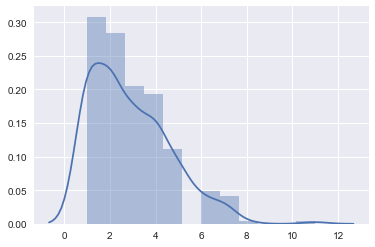

In [14]:
#Evaluate the number of words for each cancer marker
marker_length=[]
for c_word in High_priority_cancer_markers:
    marker_length.append(len(c_word.split(" ")))
    
#Plot the cancer marker word number distribution
sns.distplot(marker_length)   

There is not a lot of cancer marker name that are built with more than 7 words so we will limit our vectorization model with 7-grams

Let's focus on the Text feature and use <font size=3.5><strong>word embedding with word2vec</strong></font>

In [15]:
from gensim.models import Word2Vec
from time import gmtime, strftime

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))


#Extract text and target values
#Transform label to int
def vectorize_labels(DF, targets):
    #DF is the DataFrame containing the targets serie
    #targets is the DataFrame Serie Name that contains all target values
    i=0
    label_distinct_values = DF[targets].unique()
    for label_val in label_distinct_values:
            DF.loc[DF[targets] == label_val, targets] = i
            i=i+1

    #Vectorize int labels
    labels=[]
    for j in range(len(DF[targets])):
        label = [0 for x in label_distinct_values]
        label[DF[targets][j]] = 1
        labels.append(label)
    array_labels = np.array(labels)
    return array_labels  

x_text = train["Text"]
y_text = train["Class"]
y = vectorize_labels(train,"Class")
train.drop("Class",axis=1)

#clean x_text
# Tokenization/string cleaning
import re
def clean_str(string):
    
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

#Clean text read
x_text = [clean_str(sent) for sent in x_text]

#Merge train and test
combine = train.append(test)
combine.reset_index(inplace=True)
combine.drop('index', inplace=True, axis=1)

#Keep the train dataset length
train_shape0 = training_variants_df.shape[0]

#Create a list of list from the text
X=combine["Text"].apply(lambda x : x.split()).tolist()
combine["Text_num_words"] = combine["Text"].apply(lambda x: len(str(x).split()) )


2017-09-04 18:17:53


In [16]:
#File name to save or load the Word2Vec Model
fname="Word2VecModel"

In [17]:
#Vectorize text
from gensim.models import Word2Vec

#Train Word2Vec on the merge (train and test) tokenized text
embedding_dimension=200
w2v_model = Word2Vec(X, size=embedding_dimension, min_count=5, workers=2 )
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
print("Word2vec model built")
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

#Save the model on disk to save time at next notebook execution
w2v_model.save(fname)

Word2vec model built
2017-09-04 18:51:50


In [18]:
#Vectorize text
from gensim.models import Word2Vec

#Load the word2vec model
w2v_model = Word2Vec.load(fname)
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

<font size=3.5><strong>Explore Data with Word2vec and T-SNE</strong></font>

2017-09-04 18:54:14
Build a word2vec model with at least 500 occurences for each word in the vocabulary
2017-09-04 19:20:58
Reduce and plot the vocabulary with T-SNE


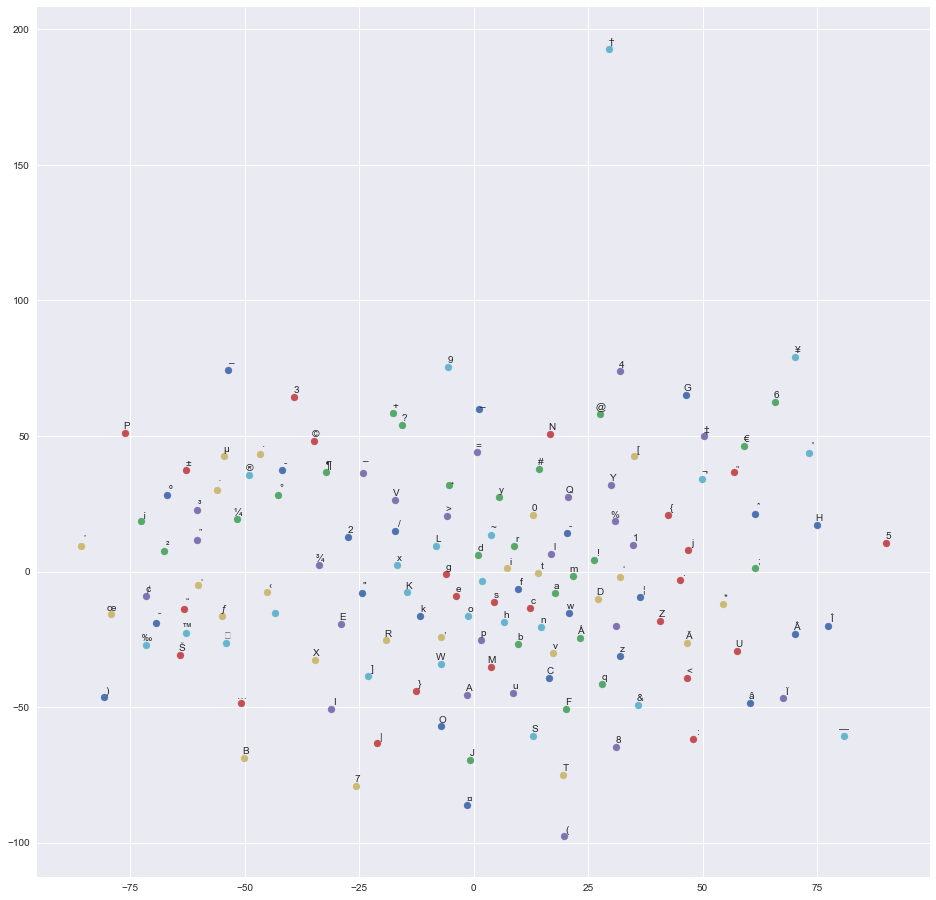

2017-09-04 19:21:04


In [19]:
from sklearn.manifold import TSNE

#Reduce word vector dimension and plot the corpus
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
#Build a selective model
print("Build a word2vec model with at least 500 occurences for each word in the vocabulary")
model_min_count_500 = Word2Vec(train["Text"], size=100, window=20, min_count=500, workers=2)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

#Plot vocabulary    
print("Reduce and plot the vocabulary with T-SNE")
tsne_plot(model_min_count_500)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))



In [20]:
#Evaluate the most similar word to cancer
print(w2v_model.most_similar('cancer'))


[('carcinoma', 0.6707070469856262), ('cancers', 0.6683247089385986), ('cancer,', 0.6569482088088989), ('cancer.', 0.6525745987892151), ('adenocarcinoma', 0.6459561586380005), ('cancers,47', 0.6087566614151001), ('Mother,', 0.6080567836761475), ('cancer.5', 0.5954639911651611), ('tumor', 0.5942410826683044), ('cancer[28,', 0.588981568813324)]


<font size=3.5><strong>Compare feature frequency and word similarity</strong></font>

Get the 10 most common Variation for the TP53 Gene and compare the frequency feature to the text similarity of each top variation  to TP53

In [21]:
TP53_top_10_variation = combine[combine["Gene"]=="TP53"]["Variation"].sort_values(ascending=False)[:10]

In [22]:
#Evaluate the distance of the 5 most variation for a gene to the gene word
for curr_variation in TP53_top_10_variation:
    if curr_variation in w2v_model.wv.vocab:
        print(curr_variation + " has a similar score with Gene TP53 of : " + str(w2v_model.similarity("TP53", curr_variation)))
    else :
        print("Variation : "+ curr_variation + " is not in the w2v vocabulary")



Variation : Y236S is not in the w2v vocabulary
Variation : Y236D is not in the w2v vocabulary
Y236C has a similar score with Gene TP53 of : 0.156223624065
Y234H has a similar score with Gene TP53 of : 0.104668291008
Y234C has a similar score with Gene TP53 of : 0.176433641758
Y220S has a similar score with Gene TP53 of : 0.13181626791
Y220C has a similar score with Gene TP53 of : 0.223609377548
Y163C has a similar score with Gene TP53 of : 0.00852609518266
Variation : V274F is not in the w2v vocabulary
V272M has a similar score with Gene TP53 of : 0.0606374069751


Some of these variation are even not present in the vocabulary, not frequent enough to be catch.

## <p id="chapII">II - Feature engineering</p>

--------------------------

--------------------------

<font size=3.5><strong>Create new features based on cancer synonyms and related words </strong></font>

--------------------



In [23]:
#Calculate the frequency ratio for a word in the row text 
def get_word_ratio(word,text, num_words):
    freq = len(re.findall(word, text))
    ratio = freq/num_words
    return ratio


<font size=3.5><strong>Use the list of cancer similar words detected by word2vec</strong></font>

In [24]:
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
combine['cancer_avg'] =  combine.apply(lambda x : get_word_ratio('cancer', x['Text'], x['Text_num_words']), axis=1)
combine['cancers_avg'] =  combine.apply(lambda x : get_word_ratio('cancers', x['Text'], x['Text_num_words']), axis=1)
combine['carcinoma_avg'] =  combine.apply(lambda x : get_word_ratio('carcinoma', x['Text'], x['Text_num_words']), axis=1)
combine['adenocarcinoma_avg'] =  combine.apply(lambda x : get_word_ratio('adenocarcinoma', x['Text'], x['Text_num_words']), axis=1)
combine['cancercomma_avg'] =  combine.apply(lambda x : get_word_ratio('cancercomma', x['Text'], x['Text_num_words']), axis=1)
combine['CRC_avg'] =  combine.apply(lambda x : get_word_ratio('crc', x['Text'], x['Text_num_words']), axis=1)
combine['tumor_avg'] =  combine.apply(lambda x : get_word_ratio('tumor,', x['Text'], x['Text_num_words']), axis=1)
combine['cancer,'] =  combine.apply(lambda x : get_word_ratio('cancer,', x['Text'], x['Text_num_words']), axis=1)
combine['cancer.']  =  combine.apply(lambda x : get_word_ratio('cancer.', x['Text'], x['Text_num_words']), axis=1)
combine['cancers,47'] =  combine.apply(lambda x : get_word_ratio('cancers,47', x['Text'], x['Text_num_words']), axis=1)
combine['Mother,'] =  combine.apply(lambda x : get_word_ratio('mother,', x['Text'], x['Text_num_words']), axis=1)
combine['cancer.5'] =  combine.apply(lambda x : get_word_ratio('cancer.5,', x['Text'], x['Text_num_words']), axis=1)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

#Gather all cancer similar words ratio to build a new feature 
combine['cancer_syn_ratio'] = combine['cancer.5'] + combine['Mother,']+combine['cancers,47']+combine['cancer.']+combine['cancer_avg'] +combine['cancers_avg']+combine['carcinoma_avg'] + combine['adenocarcinoma_avg'] + combine['cancercomma_avg'] +combine['CRC_avg'] + combine['tumor_avg'] + combine['cancer,']


2017-09-04 19:21:06
2017-09-04 19:22:00


<font size=3.5><strong>As the goal of the project is to distinguish driver and passenger mutations, evaluate these words ferquencies</strong></font>

In [25]:
#Search ratio frequency for words "driver" and "passenger"
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
combine['driver_avg'] =  combine.apply(lambda x : get_word_ratio('driver', x['Text'], x['Text_num_words']), axis=1)
combine['passenger_avg'] =  combine.apply(lambda x : get_word_ratio('passenger', x['Text'], x['Text_num_words']), axis=1)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))


2017-09-04 19:22:01
2017-09-04 19:22:02


<font size=3.5><strong>We here count occurencies of words meet text we can read related to cancer</strong></font>

In [26]:
#Add cancer synonyms and related words 
cancer_related_words = ['benign', 'malign', 'cell growth', 'abnormal cell growth', 'cell cycle', 'apoptosis', 'accumulation',
                        'spread', 'invade', 'lump', 'weight loss', 'oncological', 'survival', 'death', 'corruption', 'disease',
                        'malignancy', 'sickness', 'canker', 'carcinoma', 'big c', 'long illness', 'chemotherapy', 
                        'radiotherapy','carcinogen', 'carcinogenic', 'carcinoma', 'cytology', 'cells grow',
                        'Hodgkin', 'leukemia', 'leukaemia', 'lymphoma', 'lymph nodes', 'malignancy', 'malignant', 'melanoma',
                        'metastasis', 'precancerous', 'sarcoma']
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

#Evaluate the ratio frequency of each of these words regarding the text length
for cancer_related_word in cancer_related_words:
    combine[cancer_related_word] =  combine.apply(lambda x : get_word_ratio(cancer_related_word, x['Text'], x['Text_num_words']), axis=1)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))


2017-09-04 19:22:02
2017-09-04 19:22:37


<font size=3.5><strong> What is the biomarker frequency ? </strong></font><br><br>
We now will calculate the ratio : frequency/total number of words for important biomarkers listed here : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2716785/

In [27]:
#Add the 9 FDA approved cancer biomarker
FDA_words = ['a-fetoprotein', 'AFP', 
'hepatocellular', 'antigen-125', 'CA-125', 
'human epididymis protein 4', 'HE4', 'ovarian cancer', 
'thyroglobulin', 'Tg' , 'thyroid cancer', 
'prostate specific antigen', 'PSA', 'prostate cancer', 
'carcinogenic embryonic antigen', 'CEA', 'pancreatic cancer',
'CA15-3/CA27-29', 'HER2/neu', 'breast cancer.6']


#Evaluate the ratio frequency of each of these words regarding the text length
for FDA_word in FDA_words:
    combine[FDA_word] =  combine.apply(lambda x : get_word_ratio(FDA_word, x['Text'], x['Text_num_words']), axis=1)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))



2017-09-04 19:22:53


<font size=3.5><strong>Get dummies for Gene and Variation</strong></font>

In [28]:
def dummies(df, columns = None):
    if columns is not None:
        for column in columns:
            df = pd.concat((df, pd.get_dummies(df[column], prefix = column)), axis = 1)
            del df[column]
    return df

combine_dummies = dummies(combine,["Gene","Variation"])


In [29]:
combine_dummies.shape

(8989, 10193)

<font size=3.5><strong>Join combine_dummies and combine dataframes</strong></font>

In [30]:
combine = pd.concat((combine, combine_dummies),  axis = 1)

Split the combine dataset to reshape the train and test dataset to fit models and predict 

In [31]:
#Delete useless columns
del combine["Class"]
del combine["ID"]

In [32]:
#List the number type feature and check how many they are
combine_number_cols = combine.select_dtypes(include=[np.number]).columns
print(combine_number_cols)

Index(['Text_num_words', 'cancer_avg', 'cancers_avg', 'carcinoma_avg',
       'adenocarcinoma_avg', 'cancercomma_avg', 'CRC_avg', 'tumor_avg',
       'cancer,', 'cancer.',
       ...
       'Variation_null380R', 'Variation_null399R', 'Variation_null420W',
       'Variation_null423L', 'Variation_null462G', 'Variation_null483L',
       'Variation_null496R', 'Variation_null522S', 'Variation_null654G',
       'Variation_p61BRAF'],
      dtype='object', length=10264)


<font size=3.5><strong>Reduce the features number with TruncatedSVD</strong></font>

In [33]:
#Split combine to get back train and test datasets
def split_df( df_combined,limit ):    
    train = df_combined[:limit]
    test = df_combined[limit:]
    
    return train, test


In [34]:
#import TruncatedSVD and reduce the number of features
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
svd_data = svd.fit_transform(combine[combine_number_cols])



<font size=3.5><strong>Get back on train and test dataframe</strong></font>

In [35]:
#Split the combine dataframe reduced to train and test dataframes
train,test = split_df(svd_data,train_shape0)

## <p id="chapIII">III - Vectorize Text feature</p>

--------------------------

--------------------------

<font size=3.5><strong>Transform/Vectorize Text feature</strong></font>

--------------------




In [36]:
#Vectorize the "Text" feature with TFIDF 
tfidf = TfidfVectorizer(
    min_df=5, max_features=None, strip_accents='unicode',lowercase =True,
    analyzer='word', token_pattern=r'\w+', use_idf=True, 
    smooth_idf=True, sublinear_tf=True, 
    #ngram_range=(1,2) , 
    stop_words = 'english')

#Gathter train and test read Texts
all_texts = training_text_df.append(test_text_df)["Text"]

#Vectorize texts
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
print("Let's fit and transform the Texts with TfidfVectorizer")
tfidf.fit(all_texts)
X_tfidf_text = tfidf.transform(all_texts)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
print("Done !")

2017-09-04 19:23:18
Let's fit and transform the Texts with TfidfVectorizer
2017-09-04 19:29:05
Done !


<font size=3.5><strong>Reduce vectorized Text feature</strong></font>

In [37]:
#Text vectorized feature reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(200)
SVD_text = svd.fit_transform(X_tfidf_text)

In [38]:
SVD_text.shape

(8989, 200)

<font size=3.5><strong>Split combine to train and test dataframes</strong></font>

In [39]:
#Split train and test data
X_train_text = SVD_text[:training_text_df.shape[0]]
X_test_text = SVD_text[training_text_df.shape[0]:]

#Cast the train list to dataframe 
train_df = pd.DataFrame(data=train[:], 
                        index=[i for i in range(len(train))], 
                        columns=["Train_features_"+str(i) for i in range(len(train[0]))]) 

test_df = pd.DataFrame(data=test[:], 
                        index=[i for i in range(len(test))], 
                        columns=["Train_features_"+str(i) for i in range(len(test[0]))]) 



#Cast the vectorized text to dataframe to concatenate with other features
train_text_df = pd.DataFrame(X_train_text,columns=[i for i in range(X_train_text.shape[1])])
test_text_df = pd.DataFrame(X_test_text,columns=[i for i in range(X_train_text.shape[1])])



<font size=3.5><strong>Concatenate Text feature with all others features</strong></font>

In [40]:
#Concatenate all number features with the vectorized texts
train = pd.concat((train_df, train_text_df),  axis = 1)
test = pd.concat((test_df, test_text_df),  axis = 1)


## <p id="chapIV">IV - Build Support Vector Machine model</p>

--------------------------

--------------------------

<font size=3.5><strong>Use the One Versus Rest model to classify texts</strong></font>

--------------------


In [41]:
################### Other model with XGB ###########################
import xgboost as xgb
from sklearn import metrics 
from sklearn.model_selection import train_test_split

#The denom variable will permit to evaluate the mean of the scores obtained
denom = 0

#Predict class for several fold and evaluate the mean for the final predictions
fold = 5 
for i in range(fold):
    params = {
        'eta': 0.09,   #Learning rate
        'max_depth': 4, 
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': i,
        'silent': True
    }
    
    #Train the model on 80% of the train data
    X_train, X_test, y_train, y_test = train_test_split(train, y_text, test_size=0.2, random_state=i)
    watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
    model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    
    #Get the score with log loss metric
    score1 = metrics.log_loss(y_test, model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
    print(score1)
    
    if denom != 0: # Is it our first prediction ?
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds += pred
    else:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds = pred.copy()
    denom += 1
    submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission['ID'] = test_variants_df.ID
    submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)

#Get the predictions mean
preds /= denom

#Build the final submission file
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = test_variants_df.ID
submission.to_csv('submission_xgb.csv', index=False)


[0]	train-mlogloss:2.03973	valid-mlogloss:2.05832
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:0.594072	valid-mlogloss:0.978086
[100]	train-mlogloss:0.355258	valid-mlogloss:0.92636
[150]	train-mlogloss:0.25796	valid-mlogloss:0.943653
Stopping. Best iteration:
[96]	train-mlogloss:0.367496	valid-mlogloss:0.925622

0.925622370993
[0]	train-mlogloss:2.03769	valid-mlogloss:2.06121
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:0.591381	valid-mlogloss:0.987227
[100]	train-mlogloss:0.356429	valid-mlogloss:0.957876
[150]	train-mlogloss:0.255925	valid-mlogloss:0.982596
Stopping. Best iteration:
[80]	train-mlogloss:0.423798	valid-mlogloss:0.953934

0.953933926963
[0]	train-mlogloss:2.04148	valid-mlogloss:2.05189
Multiple eval metrics have been 